# Notebook 14 - Simulate Waste Reduction from Deployment

This notebook estimates the impact of meal box deployment by simulating how many wasted products might have been saved. It compares deployed recipe concepts with actual waste data on the snapshot day and summarizes the potential reduction in both item count and monetary value.

---

**Inputs**
- `store_mealbox_ranked.csv` - Final recipe deployment per store
- `waste_with_concept.csv` - Snapshot waste data tagged with food concepts
- `products_with_priority.csv` - Product metadata with waste/markdown flags
- `recipes_with_ontology.csv` - Ingredient-concept-recipe mapping

**Outputs**
- `simulated_waste_savings.csv` - Estimated number and value of items saved per store and concept
- Summary plots of coverage and savings impact

---


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Paths
input_folder = "cleaned_data"
output_file = os.path.join(input_folder, "simulated_waste_savings.csv")


In [2]:
# Load inputs
df_ranked = pd.read_csv(os.path.join(input_folder, "store_mealbox_ranked.csv"))
df_waste = pd.read_csv(os.path.join(input_folder, "waste_with_concept.csv"))
df_products = pd.read_csv(os.path.join(input_folder, "products_with_priority.csv"))
df_recipes = pd.read_csv(os.path.join(input_folder, "recipes_with_ontology.csv"))

print("Meal box plans:", df_ranked.shape)
print("Waste records:", df_waste.shape)
print("Products:", df_products.shape)
print("Recipes:", df_recipes.shape)


Meal box plans: (9, 4)
Waste records: (18382, 16)
Products: (126919, 35)
Recipes: (6, 6)


C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,3,5,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Explode ingredients for concept alignment
df_ranked_exploded = df_ranked.explode("ingredients").dropna()
df_ranked_exploded["ingredient_concept"] = df_ranked_exploded["ingredients"].str.strip().str.lower()

# Get unique concepts per store
concepts_per_store = (
    df_ranked_exploded.groupby("store")["ingredient_concept"]
    .apply(set)
    .reset_index()
)
concepts_per_store.columns = ["store", "deployed_concepts"]


In [4]:
# Normalize waste concept names
df_waste["product_concept"] = df_waste["product_concept"].astype(str).str.strip().str.lower()

# Keep only waste rows with valid store and product concept
df_waste_valid = df_waste[["Store", "product_concept", "Items wasted", "Value wasted"]].dropna()
df_waste_valid.rename(columns={"Store": "store"}, inplace=True)

# Ensure store column is int
df_waste_valid["store"] = df_waste_valid["store"].astype(int)

print("Filtered waste rows:", df_waste_valid.shape)


Filtered waste rows: (18382, 4)


In [5]:
# Join deployed concepts to waste data by store
df_sim = df_waste_valid.merge(concepts_per_store, on="store", how="left")

# Flag whether each waste row is covered by a deployed ingredient concept
df_sim["covered"] = df_sim.apply(
    lambda row: row["product_concept"] in row["deployed_concepts"] if isinstance(row["deployed_concepts"], set) else False,
    axis=1
)


In [6]:
# Aggregate waste savings only for covered rows
df_covered = df_sim[df_sim["covered"]]

df_savings = (
    df_covered.groupby(["store", "product_concept"])
    .agg(
        items_saved=("Items wasted", "sum"),
        value_saved=("Value wasted", "sum")
    )
    .reset_index()
)

print("Simulated saved rows:", df_savings.shape)
display(df_savings.head())


Simulated saved rows: (0, 4)


,store,product_concept,items_saved,value_saved


In [7]:
# Compute total savings per store
df_totals = (
    df_savings.groupby("store")
    .agg(
        total_items_saved=("items_saved", "sum"),
        total_value_saved=("value_saved", "sum")
    )
    .reset_index()
)

# Preview
print("Store-level savings summary:")
display(df_totals.sort_values("total_value_saved", ascending=False).head())


Store-level savings summary:


,store,total_items_saved,total_value_saved


In [11]:
# Reference concepts from waste and markdown tags
waste_concepts = set(df_products[df_products["waste_flag"] == 1]["product_concept"].dropna())
markdown_concepts = set(df_products[df_products["markdown_flag"] == 1]["product_concept"].dropna())

# Unique deployed ingredient concepts
deployed_concepts = set(df_ranked_exploded["ingredient_concept"])

In [12]:
missed_concepts = waste_concepts.difference(deployed_concepts)
print("Missed waste concepts:", missed_concepts)


Missed waste concepts: {'strawberries', 'honey', 'yogurt', 'banana'}


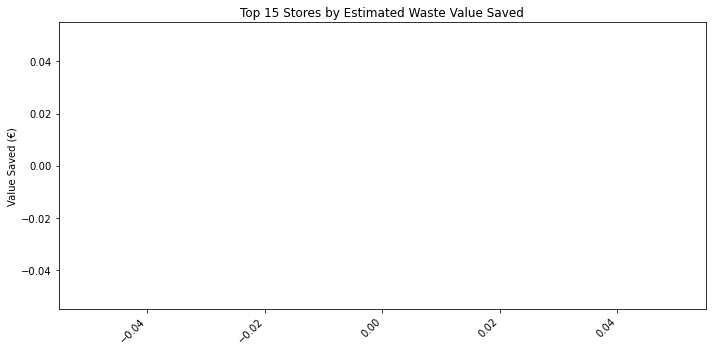

In [8]:
plt.figure(figsize=(10, 5))
top_stores = df_totals.sort_values("total_value_saved", ascending=False).head(15)
plt.bar(top_stores["store"].astype(str), top_stores["total_value_saved"])
plt.title("Top 15 Stores by Estimated Waste Value Saved")
plt.ylabel("Value Saved (€)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:
# Save detailed savings per concept per store
df_savings.to_csv(output_file, index=False)
print("Saved simulated savings to:", output_file)


Saved simulated savings to: cleaned_data\simulated_waste_savings.csv


### Summary

This notebook simulated how effective the deployed meal boxes would be in reducing food waste by:

- Comparing deployed recipe ingredient concepts against real waste on the snapshot date.
- Quantifying how many items and how much value would have been saved.
- Visualizing store-level impact in terms of euros recovered.

The results allow Dirk to:

- Prioritize rollout to stores with higher simulated savings.
- Refine future meal box planning to align with high-waste concepts.
- Provide quantitative evidence of potential waste reduction for stakeholders.

Next: Notebook 15 will continue with exporting ingredient-level inventory instructions for store operations, or Notebook 16 will analyze strategy-level optimizations for future rollout.
